In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai imports
from fastai.vision import *

# import path to use path objects instead of strings
from pathlib import Path

In [3]:
! pwd

/home/titus/fastai/SATAI


In [6]:
path = Path('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000')
path_part1 = path/'HAM10000_images_part_1'
path_part2 = path/'HAM10000_images_part_2'
data_path = path/"HAM10000_metadata.csv"

In [12]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c: Union[pathlib.Path, str], check_ext: bool = True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



#### Get images

Obtaining images from path 1

In [42]:
fnames_1 = get_image_files(path_part1)
fnames_1[:3]

[PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026902.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025846.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025998.jpg')]

Obtaining images from path 2

In [43]:
fnames_2 = get_image_files(path_part2)
fnames_2[:3]

[PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030678.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033076.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032350.jpg')]

Joining images

In [44]:
fnames = fnames_1 + fnames_2

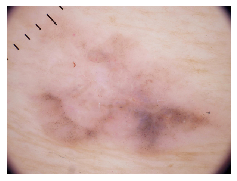

In [45]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(4,4))

In [7]:
df = pd.read_csv(data_path)
df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


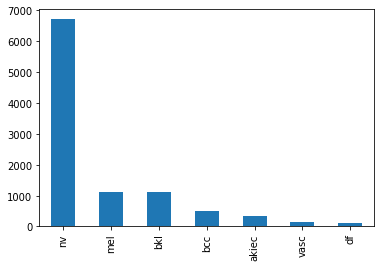

In [8]:
df['dx'].value_counts().plot(kind = 'bar')

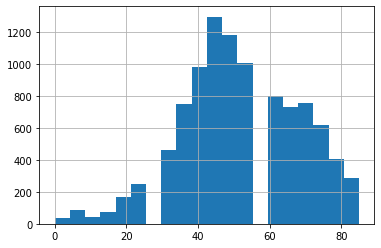

In [9]:
df['age'].hist(bins = 20)

We define the batch size and the size of the images

In [10]:
#bs = 64
bs = 32

size = 224

#### Transform

In [11]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [25]:
doc(ImageDataBunch)

In [13]:
data = ImageDataBunch.from_csv(path, 
                               folder='images',
                               csv_labels='HAM10000_metadata.csv', 
                               suffix='.jpg', 
                               fn_col=1, 
                               label_col=2, 
                               ds_tfms=tfms, 
                               valid_pct = 0.2,
                               size=size, 
                               bs=bs)
print('Transforms = ', len(tfms))
# Save the DataBunch in case the training goes south... so you won't have to regenerate it..
# Remember: this DataBunch is tied to the batch size you selected. 
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

Transforms =  2
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nv,bcc,mel,mel,nv
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Test: None

In [52]:
data = ImageDataBunch.from_df(
    path = path/'images',    # path to images folder
    df = df,                 # dataframe
    suffix = '.jpg',         # image extension
    fn_col = 1,              # image_id column as name
    label_col = 2,           # dx as label
    ds_tfms=tfms,            # data augmentation
    size = size,             # image size
    bs = bs                  # batch size
)
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

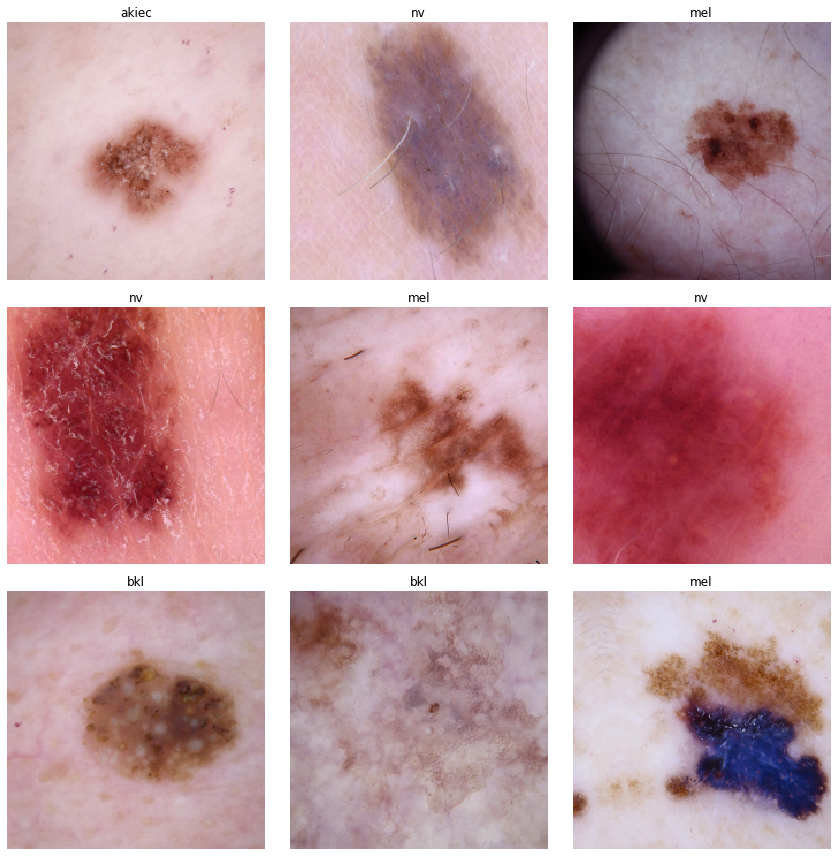

In [14]:
data.show_batch(rows=3)


In [ ]:
! /usr/bin/nvidia-smi

In [15]:
data.normalize(imagenet_stats)  

ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nv,bcc,mel,mel,nv
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Test: None

In [22]:
learner = cnn_learner(
    data, 
    models.resnet34, 
    metrics=[error_rate, Recall(), Precision(), FBeta(), MatthewsCorreff()], 
    path=path/'models'
)

In [21]:
doc(cnn_learner)

In [17]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [18]:
defaults.device = torch.device('cuda')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


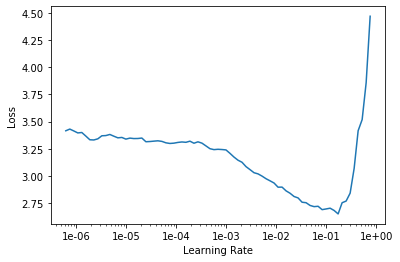

In [19]:
learner.lr_find()
learner.recorder.plot()

In [23]:

learner.fit_one_cycle(8, max_lr=slice(2e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,1.203531,0.744939,0.246630,0.471110,0.536560,0.478239,0.499213,11:20
1,0.837539,0.610706,0.224164,0.521710,0.603332,0.536218,0.553849,11:13
2,0.705035,0.564594,0.201198,0.649135,0.629574,0.645126,0.616463,10:36
3,0.603426,0.654172,0.223165,0.486770,0.707966,0.519214,0.520550,10:40
4,0.533937,0.506372,0.181228,0.601580,0.693773,0.618005,0.631367,10:29
5,0.488058,0.450989,0.161258,0.643366,0.737116,0.660158,0.674154,10:29
6,0.431676,0.420425,0.155766,0.682996,0.734673,0.692741,0.690154,10:30
7,0.399598,0.413334,0.150275,0.686876,0.752163,0.699011,0.700285,10:29


/home/titus/.local/lib/python3.7/site-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [24]:
learner.save('stage-1-rn34')